In [1]:
%matplotlib notebook

/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from itertools import product, combinations
from io import StringIO

import numpy as np
from numpy.linalg import norm
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

from networkx import Graph
from networkx.algorithms import astar_path

In [3]:
# Radius of earth
RADIUS = 6371.0 # km

# Plotting utilities

In [4]:
class Arrow3D(FancyArrowPatch):
    # Adapted from https://stackoverflow.com/questions/11140163/python-matplotlib-plotting-a-3d-cube-a-sphere-and-a-vector
    
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

def plot_3d_point(x, y, z, color='b', s=10, ax=None):
    ax = ax or plt.gca()
    ax.scatter([x],[y],[z], facecolor=color, color=color, s=s)
        
def create_sphere_fig():
    # Adapted from https://stackoverflow.com/questions/11140163/python-matplotlib-plotting-a-3d-cube-a-sphere-and-a-vector
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_aspect("equal")
    

    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:40j]
    x=np.cos(u)*np.sin(v)*RADIUS
    y=np.sin(u)*np.sin(v)*RADIUS
    z=np.cos(v)*RADIUS
    ax.plot_wireframe(x, y, z, color="k", alpha=.1)

    for sat_name, lat, lon, alt in satellites.itertuples():    
        plot_3d_point(*xyz(lat, lon, alt), color='b', s=10, ax=ax)
    
    return fig, ax

# Coordinate transformations and intersection test

In [5]:
def xyz(lat, lon, alt, radius=RADIUS):
    """
    Calculate XYZ coordinates corresponding to latitude, longitude and altitude coordinates
    
    :param lat: latitude in degrees
    :type lat: pd.Series[float]|np.array[float]
    :param lon: longitude in degrees
    :type lon:  pd.Series[float]|np.array[float]
    :param alt: altitude in kilometers
    :type alt:  pd.Series[float]|np.array[float]
    :param radius: radius of the sphere to use in calculations, in kilometers
    :type radius: float
    :return: 3-tuple of x, y, and z coordinates
    :rtype: (np.array[float], np.array[float], np.array[float])
    
    http://www.movable-type.co.uk/scripts/latlong-vectors.html
    https://en.wikipedia.org/wiki/Geographic_coordinate_conversion#From_geodetic_to_ECEF_coordinates
    """
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    alt = np.asarray(alt)
    lat_rad = np.deg2rad(lat)
    lon_rad = np.deg2rad(lon)
    
    # XXX: hack to handle numerical inaccuracies with location on the earth
    alt[alt == 0] = 1e-6
    

    # right-handed vector: x -> 0°E,0°N; y -> 90°E,0°N, z -> 90°N
    x = np.cos(lat_rad) * np.cos(lon_rad) * (radius + alt)
    y = np.cos(lat_rad) * np.sin(lon_rad) * (radius + alt)
    z = np.sin(lat_rad) * (radius + alt)
        
    
    return x, y, z

In [6]:
def line(xyz1, xyz2):
    """
    
    :return : 3-tuple of line origin (in XYZ), distance, and unit vector (in XYZ)
    :rtype: (np.array[float], float, np.array[float])
    """
    line_vec = np.asarray(xyz2) - np.asarray(xyz1)
    dist = norm(line_vec)
    origin = np.asarray(xyz1)
    return origin, dist, line_vec / dist

In [7]:

def does_not_intersect_sphere(line):
    """
    
    See https://en.wikipedia.org/wiki/Line%E2%80%93sphere_intersection
    """
    # A small treshold is added to all comparisons due to numerical inaccuracies
    # (we want to make the tests cases below pass)
    EPSILON = 1e-8
    
    origin, dist, direc = line
    discriminant = np.dot(direc, origin)**2 - norm(origin)**2 + RADIUS**2
    if discriminant <= EPSILON:
        return True
    else:
        # line intersects with sphere. Let's see if the line *segment* intersects
        d1 = - np.dot(direc, origin) + np.sqrt(discriminant)
        d2 = - np.dot(direc, origin) - np.sqrt(discriminant)
        # If intersects "before" line origin pt1 (d < 0), or "after" pt2 (dX > dist)
        # then the segment does not intersect
        return (d1 < EPSILON or d1 > dist + EPSILON) and (d2 < EPSILON or d2 > dist + EPSILON)

In [8]:
def line_of_sight_points_xyz(pt1, pt2):
    """
    :param pt1: point entry, should have at least x, y, z keys
    :type pt1: pd.Series
    :param pt2: point entry, should have at least x, y, z keys
    :type pt2: pd.Series
    """
    return does_not_intersect_sphere(line(pt1[['x', 'y', 'z']], pt2[['x', 'y', 'z']]))



## Small set of tests for the intersecion

In [9]:
def test_line_of_sight(lat_lon_alt1, lat_lon_alt2):
    XYZ = list('xyz')
    xyz1 = pd.Series(dict(zip(XYZ, xyz(*lat_lon_alt1))))
    xyz2 = pd.Series(dict(zip(XYZ, xyz(*lat_lon_alt2))))
    no_intersect = line_of_sight_points_xyz(xyz1, xyz2)
    
    print('(lat, lon, altitude) line ({}, {}, {}) -> ({}, {}, {}) intersects sphere'
          ': {}'.format(lat_lon_alt1[0], lat_lon_alt1[1], lat_lon_alt1[2],
                                       lat_lon_alt2[0], lat_lon_alt2[1], lat_lon_alt2[2],
                                       not no_intersect))



In [10]:
# from ground to up in the air -> no intersection
test_line_of_sight((60., 30., 0),
                     (60., 30., 3.))

(lat, lon, altitude) line (60.0, 30.0, 0) -> (60.0, 30.0, 3.0) intersects sphere: False


In [11]:
# below ground -> intersects for sure
test_line_of_sight((60., 30., -1),
                     (60., 30., 3.))

(lat, lon, altitude) line (60.0, 30.0, -1) -> (60.0, 30.0, 3.0) intersects sphere: True


In [12]:
# would definately cross the globe
test_line_of_sight((60., 30., 1e-6),
                     (60., 30.+180, 1e-6))

(lat, lon, altitude) line (60.0, 30.0, 1e-06) -> (60.0, 210.0, 1e-06) intersects sphere: True


In [13]:
# does not intersect earth since so high up
test_line_of_sight((60., 30., 1e6),
                    (60., 30.+180, 1e6))

(lat, lon, altitude) line (60.0, 30.0, 1000000.0) -> (60.0, 210.0, 1000000.0) intersects sphere: False


# Read the data

In [14]:
# Whether to query new data from the web page
new_data = False

if new_data:
    from urllib.request import urlopen
    data = urlopen('https://space-fast-track.herokuapp.com/generate').read().decode('UTF-8')
else:
    data="""#SEED: 0.48707564012147486
SAT0,86.80648816144344,87.32696768076761,333.22411386596013
SAT1,-82.19280439893762,-84.03297351739013,693.430855041359
SAT2,-66.60448634461679,-130.40300607493526,552.8234984988256
SAT3,-29.059263736211093,149.37078445219788,644.5244975237069
SAT4,27.537771238520207,72.2240250255604,605.4381522882712
SAT5,-74.24236899288545,84.88636123550691,636.3114485483843
SAT6,-33.912630167757385,27.644169528494302,624.7334076427674
SAT7,23.01567028829467,-55.07433987960175,684.4932767991103
SAT8,61.87960639467008,-132.03337102080377,422.6312501987021
SAT9,-42.720890323998475,136.62235201844294,410.266650749838
SAT10,-36.58198565810919,17.89685705376982,634.8807599667084
SAT11,84.49547385487719,-147.84740576708913,392.8271393229308
SAT12,-43.18395760269878,-115.56543707413842,562.4333137812591
SAT13,82.43708200581915,124.564228992822,510.2523376229691
SAT14,-53.63476413054712,26.074117178988132,589.2473857738445
SAT15,48.86418809073413,-44.917213347118434,566.9049848441086
SAT16,46.76000136518158,22.70600409514637,483.4756589616101
SAT17,-49.42365922203435,-40.52576182716996,531.6450281394214
SAT18,40.218340101457756,-8.277155859200036,339.8124784485469
SAT19,60.47139402682575,-169.8981121880014,331.11357870314396
ROUTE,-46.313684094644906,-87.63447321311904,-40.48190998748188,166.87346401653804"""

In [15]:
print(data.split('\n', 1)[0])

#SEED: 0.48707564012147486


In [16]:
# Read the CSV, skipping first row, and indexing the rows with ID. Remove the ROUTE row for now
satellites = (pd.read_csv(StringIO(data), skiprows=1, 
            names=['ID', 'latitude', 'longitude', 'altitude'], index_col='ID'))
satellites = satellites[satellites.index != 'ROUTE']


In [17]:
satellites.head()

,latitude,longitude,altitude
ID,,,
SAT0,86.806488,87.326968,333.224114
SAT1,-82.192804,-84.032974,693.430855
SAT2,-66.604486,-130.403006,552.823498
SAT3,-29.059264,149.370784,644.524498
SAT4,27.537771,72.224025,605.438152


In [18]:
# Read route start and end points
route = pd.read_csv(StringIO(data.splitlines()[-1]),
            names=['ID', 'lat1', 'lon1', 'lat2', 'lon2'],
                        usecols=range(1, 5)).dropna()

In [19]:
route

,lat1,lon1,lat2,lon2
0,-46.313684,-87.634473,-40.48191,166.873464


In [20]:
start_and_end = pd.DataFrame(np.concatenate([route[['lat1', 'lon1']].values,
               route[['lat2', 'lon2']].values]), columns=['latitude', 'longitude'], index=['start', 'end'])
start_and_end['altitude'] = 0
start_and_end

,latitude,longitude,altitude
start,-46.313684,-87.634473,0
end,-40.481910,166.873464,0


In [21]:
points = pd.concat([satellites, start_and_end])

In [22]:
# Pre-calculate X, Y and Z
points['x'], points['y'], points['z'] = xyz(points['latitude'], points['longitude'], points['altitude'])

In [23]:
points

,latitude,longitude,altitude,x,y,z
ID,,,,,,
SAT0,86.806488,87.326968,333.224114,17.417810,373.075504,6693.812983
SAT1,-82.192804,-84.032974,693.430855,99.759629,-954.432865,-6998.949152
SAT2,-66.604486,-130.403006,552.823498,-1781.975734,-2093.591847,-6354.586336
SAT3,-29.059264,149.370784,644.524498,-5276.817396,3124.333967,-3407.538615
SAT4,27.537771,72.224025,605.438152,1888.576920,5890.713646,3225.439389
SAT5,-74.242369,84.886361,636.311449,169.614010,1895.391953,-6743.970208
SAT6,-33.912630,27.644170,624.733408,5142.943243,2693.716086,-3903.115980
SAT7,23.015670,-55.074340,684.493277,3717.820981,-5324.288253,2758.577012
SAT8,61.879606,-132.033371,422.631250,-2143.951076,-2378.311753,5991.705313


# Shortest path

In [24]:
# Build a nondirected graph. Each point (satellite, route start/end points) 
# will be a node in the graph.
# Nodes that have line-of-sight connections are connected using undirected edges.

# No edge weights are specified in this case (i.e. they are considered the same), 
# but euclidean distance could be used also by modifying the 
# add_edge call.

g = Graph()
for pt1_index, pt2_index in combinations(range(len(points)), 2):
    pt1_name, pt2_name = points.index[pt1_index], points.index[pt2_index]
    pt1, pt2 = points.loc[pt1_name], points.loc[pt2_name]
    
    g.add_node(pt1_name, points.loc[pt1_name].to_dict())    
    g.add_node(pt2_name, points.loc[pt2_name].to_dict())
    if line_of_sight_points_xyz(pt1, pt2):
        _, line_dist, _ = line(pt1, pt2)
        g.add_edge(pt1_name, pt2_name)


In [25]:
# Find the least-links path using Dijikstra
# method says astar but since we do not have heuristic 
# defined, it is dijikstra in practice
least_links_path = astar_path(g, 'start', 'end')
least_links_path

['start', 'SAT12', 'SAT2', 'SAT5', 'SAT9', 'SAT3', 'end']

In [26]:
# Plot the route. For validation purposes we check line-of-sight again
def _plot_route(route):
    fig, ax = create_sphere_fig()
    XYZ = list('xyz')

    for node_name1, node_name2 in zip(route[:-1], route[1:]):

        node1 = points.loc[node_name1]
        node2 = points.loc[node_name2]
        print(node_name1, '->', node_name2)

        ax.text(*node1[XYZ], s=node_name1, fontsize=10)
        ax.text(*node2[XYZ], s=node_name2, fontsize=10)

        plot_3d_point(*node1[XYZ], color='g', s=50 if node_name1 == route[0] else 25)
        plot_3d_point(*node2[XYZ], color='g', s=50 if node_name2 == route[-1] else 25)

        color = 'g' if line_of_sight_points_xyz(node1, node2) else 'r'
        xyz_pairs = list(zip(node1[XYZ], node2[XYZ]))

        a = Arrow3D(*xyz_pairs, mutation_scale=10, lw=1, arrowstyle="-|>", color=color)
        ax.add_artist(a)
  



<IPython.core.display.Javascript object>


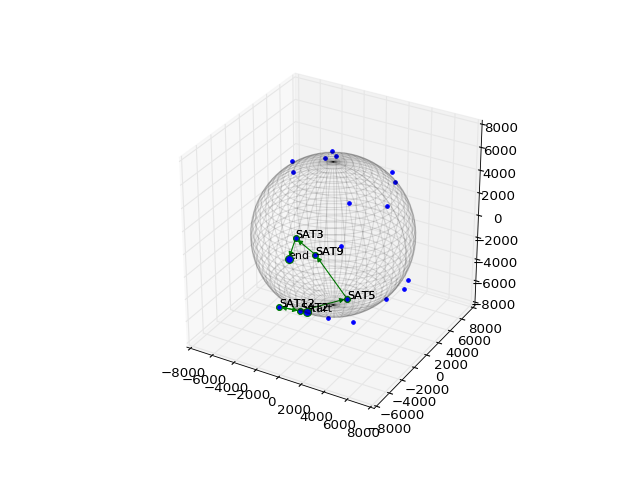

start -> SAT12
SAT12 -> SAT2
SAT2 -> SAT5
SAT5 -> SAT9
SAT9 -> SAT3
SAT3 -> end


In [27]:
_plot_route(least_links_path)